In [9]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from datetime import datetime as dt, timedelta, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/packages/gpd_lite_toolbox')
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
from target_fire_functions import *
import itertools

In [20]:
#Load county grid and fire data
data_dir = data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'
county_grid = gpd.read_file(os.path.join(data_dir, 'clean_data/county_grid/county_grid.dbf'))
fire_data = gpd.read_file(os.path.join(data_dir, 'clean_data/fire_gis/fire_gis.dbf'))

In [21]:
fire_data['start_date'] = pd.to_datetime(fire_data['ALARM_DATE'], format = '%Y-%m-%d', errors = 'coerce')
fire_data['end_date'] = pd.to_datetime(fire_data['CONT_DATE'], format = '%Y-%m-%d', errors = 'coerce')
fire_data.drop(['ALARM_DATE', 'CONT_DATE'], axis = 1, inplace = True)
fire_data.dropna(subset = ['start_date', 'end_date'], inplace = True)
fire_data = fire_data[(fire_data['YEAR']>=1990) &  (fire_data['YEAR']<=2018)]

In [7]:
county_grid.rename(columns = {'COUNTY_ARE': 'COUNTY_AREA'}, inplace = True)

## Target Variable Creation

In [4]:
##Start by creating empty array into which we will fill data for selected timeframe and area
def generate_target_frame(grid_data, min_year, max_year):
    '''
    Purpose:
    --------
    Create shell target dataframe that has dates and grid ids broken down at all time intervals we may be interested in
    (days, weeks, and months - creating all of these at once reduces need to merge and combine dataframes later)
    Inputs:
    ------
        - grid_data : GeoDataFrame that will tell us the number of sections of the map for each we want to create observations
        - min_year : minimum year for which we want to include training data (inclusive)
        - max_year : max year for which we want to include training data (inclusive)
    Output(s):
    ---------
        - target_frame: pandas DataFrame w/ two columns
            1. date : will have all dates on the user input time interval between min and max input dates
            2. GRID_ID : column of grid ids for each date (i.e. will be colmn with lots of repeated grid ids)
                                     
    '''
    #get number of map sections
    n_areas = len(grid_data)
    #get number of time intervals
    years = max_year - min_year + 1
    
    #Generate day data first
    target_frame = pd.DataFrame(pd.date_range(f'1/1/{min_year}', f'12/31/{max_year}', freq = 'D'), columns = ['date'])
    print(target_frame.shape)
    #Get year, month, and week values from this date column
    target_frame['year'] = target_frame['date'].apply(lambda x:x.year)
    target_frame['month'] = target_frame['date'].apply(lambda x:x.month)
    target_frame['week'] = target_frame['date'].apply(lambda x:x.week)
    
    #Generate month data
    target_frame['month_id'] = target_frame['year'].astype(str) + '_' + target_frame['month'].astype(str)
    
    #get min and max date values for each month and then merge back onto full dataframe
    month_grp = target_frame[['month_id', 'date']].groupby(['month_id']).agg({'date' : ['min', 'max']}).reset_index()
    month_grp.columns = ['_'.join(col).strip() for col in month_grp.columns.values]
    month_grp.rename(columns = {'month_id_': 'month_id', 'date_min': 'month_start', 'date_max': 'month_end'}, \
                     inplace = True)
    target_frame = target_frame.merge(month_grp, on = 'month_id')
    
    #Generate week data - deal with weeks that start in december (assign them to the previous year)
    target_frame['week_id'] = np.where((target_frame['month'] ==12) & (target_frame['week'] ==1),
                                        target_frame['year'].apply(lambda x: str(x+1))+"_"+ target_frame['week'].astype(str), 
                                       target_frame['year'].astype(str) + '_' + target_frame['week'].astype(str))
    
    #get min and max date values for each month and then merge back onto full dataframe
    print(target_frame[(target_frame['week']==1) & (target_frame['month']==12)])
    week_grp = target_frame[['week_id', 'date']].groupby(['week_id']).agg({'date' : ['min', 'max']}).reset_index()
    week_grp.columns = ['_'.join(col).strip() for col in week_grp.columns.values]
    week_grp.rename(columns = {'week_id_': 'week_id', 'date_min': 'week_start', 'date_max': 'week_end'}, \
                     inplace = True)
    week_grp.sort_values(['week_start'], inplace = True)
    target_frame = target_frame.merge(week_grp, on = 'week_id')
    
    n_dates = len(target_frame)
    #Duplicate dates x # of times for grid sections we have
    target_frame = pd.concat([target_frame]*n_areas)
    target_frame['GRID_ID'] = list(itertools.chain(*[np.repeat(i, n_dates) for i in grid_data['GRID_ID'].sort_values()]))
    target_frame.drop(['year', 'month', 'week'], inplace = True, axis = 1)
    return target_frame

In [27]:
target_frame = generate_target_frame(county_grid, 1990, 2019)
target_frame.head()

(10957, 1)
            date  year  month  week month_id month_start  month_end week_id
364   1990-12-31  1990     12     1  1990_12  1990-12-01 1990-12-31  1991_1
728   1991-12-30  1991     12     1  1991_12  1991-12-01 1991-12-31  1992_1
729   1991-12-31  1991     12     1  1991_12  1991-12-01 1991-12-31  1992_1
2555  1996-12-30  1996     12     1  1996_12  1996-12-01 1996-12-31  1997_1
2556  1996-12-31  1996     12     1  1996_12  1996-12-01 1996-12-31  1997_1
2919  1997-12-29  1997     12     1  1997_12  1997-12-01 1997-12-31  1998_1
2920  1997-12-30  1997     12     1  1997_12  1997-12-01 1997-12-31  1998_1
2921  1997-12-31  1997     12     1  1997_12  1997-12-01 1997-12-31  1998_1
4382  2001-12-31  2001     12     1  2001_12  2001-12-01 2001-12-31  2002_1
4746  2002-12-30  2002     12     1  2002_12  2002-12-01 2002-12-31  2003_1
4747  2002-12-31  2002     12     1  2002_12  2002-12-01 2002-12-31  2003_1
5110  2003-12-29  2003     12     1  2003_12  2003-12-01 2003-12-31  2004_1
5

,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID
0,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
1,1990-01-02,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
2,1990-01-03,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
3,1990-01-04,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
4,1990-01-05,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0


In [11]:
county_grid.head()

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_AREA,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,geometry
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,49.0,4.936293e+09,0.427385,"POLYGON ((-13502275.000 4897930.000, -13431275..."
1,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,50.0,1.535563e+09,0.365571,"POLYGON ((-13502275.000 4826930.000, -13431275..."
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,65.0,2.544187e+09,0.605694,"POLYGON ((-13431275.000 4826930.000, -13360275..."
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,39.0,2.029400e+09,0.482585,"POLYGON ((-13573275.000 4684930.000, -13502275..."
4,Contra Costa,013,06013,1871930816,209819213,3.351027e+09,5.041000e+09,40.0,1.618024e+09,0.482844,"POLYGON ((-13573275.000 4613930.000, -13502275..."


In [14]:
fire_data.head()

,AGENCY,FIRE_NAME,INC_NUM,CAUSE,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,FIRE_KEY,YEAR,geometry,start_date,end_date
0,CCO,OCTOBER,00246393,14.0,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,OCTOBER_2007_00246393_00233414,2007,"POLYGON ((-13191194.231 4080267.936, -13191133...",2007-10-21,2007-10-23
1,CCO,MAGIC,00233077,14.0,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,MAGIC_2007_00233077_00233077,2007,"POLYGON ((-13200763.900 4085308.071, -13200737...",2007-10-22,2007-10-25
2,USF,RANCH,00000166,2.0,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,RANCH_2007_00000166_00000166,2007,"POLYGON ((-13219907.361 4109183.199, -13219694...",2007-10-20,2007-11-15
3,CCO,EMMA,00201384,14.0,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,EMMA_2007_00201384_00201384,2007,"POLYGON ((-13143800.871 4096406.674, -13143793...",2007-09-11,2007-09-11
4,CCO,CORRAL,00259483,14.0,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,CORRAL_2007_00259483_00259483,2007,"POLYGON ((-13218530.800 4039723.471, -13218504...",2007-11-24,2007-11-27


In [22]:
##Limit fire and grid data to just columns we need for target generate
grid_target_subset = county_grid[['NAME', 'COUNTYFP', 'COUNTY_ARE','GRID_AREA', 'GRID_ID', 'geometry']]
fire_target_subset = fire_data[['FIRE_AREA', 'FIRE_KEY', 'YEAR', 'start_date', 'end_date', 'geometry']]

In [9]:
print(fire_data[['start_date', 'end_date']].iloc[10])
pd.date_range(fire_data['start_date'].iloc[10], fire_data['end_date'].iloc[10], freq = 'w')

start_date   2007-10-22
end_date     2007-10-23
Name: 10, dtype: datetime64[ns]


DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')

In [52]:
def disaggregate_fire_data(grid, fire_data):
    ''' 
    Purpose: Create instances of wildfires occuring on a daily level. This function starts with daily because it
    is easier to aggregate up once we have all days represented in one dataframe
    -------
    Inputs:
    -------
        - grid : GeoDataFrame of grid sections
        - fire_data : GeoDataFrame of fire data
    '''
    #Overlay grid and fire to get intersection geometry (this will create a dataframe with a few more fire
    #instances than we had in the plain fire_data 
    ##** Note that this will automatically exclude grid sections where this is no fire
    fire_grid = gpd.overlay(grid, fire_data, how = 'intersection')
    fire_grid['FIRE_GRID_INT_AREA'] = fire_grid.geometry.area
    fire_grid['FIRE_GRID_INT_AREA'] = fire_grid['FIRE_GRID_INT_AREA'].astype(float)
    fire_grid.index = range((len(fire_grid)))
    
    #create list of fires that had to be dropped due to data isseus (i.e. start date after end date)
    fires_dropped = []
    disagg_fire = pd.DataFrame()
    for row in fire_grid.itertuples():
        date_range = pd.date_range(row[list(fire_grid.columns).index('start_date')+1], \
                                   row[list(fire_grid.columns).index('end_date')+1], freq = 'D')
        if len(date_range) == 0:
            fires_dropped.append(row[list(fire_grid.columns).index('FIRE_KEY')])
            continue
        dup_fire_data = pd.concat([pd.Series(row[1:], index = list(fire_grid.columns)).to_frame().transpose()]*len(date_range))
        dup_fire_data['date'] = date_range
        disagg_fire = disagg_fire.append(dup_fire_data, ignore_index = True)
        if row[0] in(np.arange(0,9000, 250)):
            print(row[0], row[list(fire_grid.columns).index('GRID_ID')+1], len(disagg_fire))
            print(disagg_fire['date'].head())
    return disagg_fire, fires_dropped


In [24]:
fire_instances, fires_dropped = disaggregate_fire_data(grid_target_subset, fire_target_subset, 1990, 2019)

0 49.0 23
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
250 52.0 3324
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
500 90.0 4651
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
750 68.0 6283
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1000 102.0 8466
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1250 112.0 9121
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1500 114.0 9954
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1750 11.0 11462
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
2000 29.0 12

In [84]:
test = gpd.GeoDataFrame(fire_instances, geometry = fire_instances.geometry, crs={'init' :'epsg:3857'})
test_max = test[test['FIRE_GRID_INT_AREA']== test['FIRE_GRID_INT_AREA'].max()]

<AxesSubplot:>

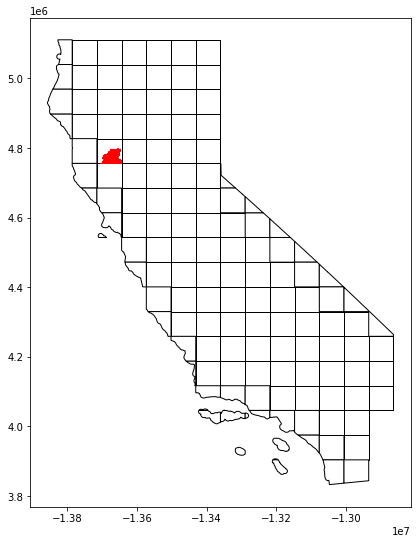

In [85]:
#Plot this fire data onto the grid
ax = county_grid.plot(color = 'white', edgecolor = 'black', figsize = (9,9))
test_max.plot(ax=ax, color = 'red', alpha = 0.5, figsize = (9,9))

Plot the sections of the grid where we apparently don't have fires against fire map just to make sure visually this tracks

<AxesSubplot:>

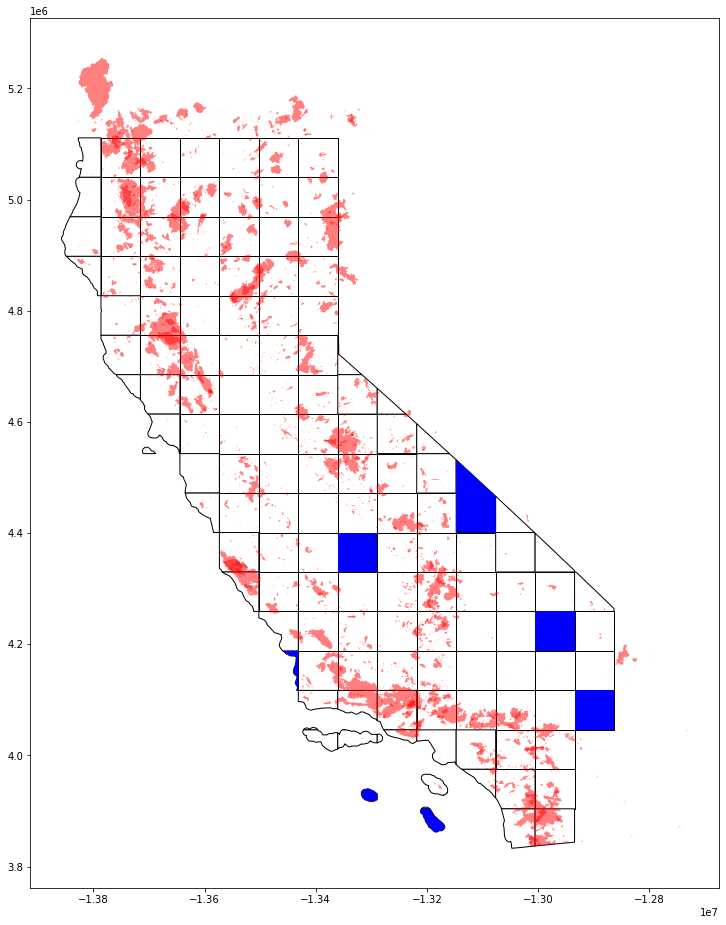

In [353]:
#Plot this fire data onto the grid
ax = county_grid.plot(color = 'white', edgecolor = 'black', figsize = (16,16))
county_grid[county_grid['GRID_ID'].isin(gs_no_fires)].plot(ax=ax, color = 'blue',figsize = (16,16))
fire_data.plot(ax=ax, color = 'red', alpha = 0.5, figsize = (16,16))

Merge fire data onto full target dataframe of dates and grid sections that we've generated 

In [28]:
print(len(fire_instances))
print(len(target_frame))
target_full = pd.merge(target_frame, fire_instances,on = ['date', 'GRID_ID'], how = 'outer') 
target_full.head()
print(target_full.shape)

74445
1468238
(1492566, 19)


# Create full target dataframe will all target data options by different time intervals

### Option 1 : binary flag
Create binary 0,1 flag if wildfire occurred in a given grid section for a given time period 

In [30]:
target_full.sort_values('date', inplace = True)
target_full.head()
target_full['Y_bin'] = np.where(target_full['FIRE_KEY'].isna()== True, 0, 1)   

### Option 2: counts of fires
Count the number of distinct fires occurring in any one area on a given day 

In [31]:
target_fire_count = target_full[['date', 'GRID_ID', 'FIRE_KEY']].groupby(['date', 'GRID_ID']).count().reset_index()
target_fire_count.rename(columns = {'FIRE_KEY': 'Y_fire_count'}, inplace = True)
print(target_fire_count.shape)
#Merge onto target_options
target_full = target_full.merge(target_fire_count, on = ['date', 'GRID_ID'])
target_full.head()

(1468238, 3)


,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID,NAME,COUNTYFP,...,GRID_AREA,FIRE_AREA,FIRE_KEY,YEAR,start_date,end_date,geometry,FIRE_GRID_INT_AREA,Y_bin,Y_fire_count
0,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0,0
1,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,118,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0,0
2,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0,0
3,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,117,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0,0
4,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,116,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0,0


### Option 3: area of fires

In [51]:
target_full['FIRE_GRID_INT_AREA'].describe()

count     7.444500e+04
unique    6.442000e+03
top       3.601862e+06
freq      3.320000e+03
Name: FIRE_GRID_INT_AREA, dtype: float64

In [57]:
### Option 3: area of fires
target_full['FIRE_GRID_INT_AREA'] = target_full['FIRE_GRID_INT_AREA'].fillna(0).astype(float) 
print(target_full['FIRE_GRID_INT_AREA'].describe())
target_full['Y_fire_area_prop'] = np.where(target_full['FIRE_GRID_INT_AREA'].isna(), 0, 
                                           target_full['FIRE_GRID_INT_AREA']/target_full['GRID_AREA'])
target_full['Y_fire_area_prop'] = target_full['Y_fire_area_prop'].astype(float)
print(target_full[target_full['Y_fire_area_prop']!=0]['Y_fire_area_prop'].describe())

count    1.492566e+06
mean     2.036108e+06
std      2.920200e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.651920e+09
Name: FIRE_GRID_INT_AREA, dtype: float64
count    7.444500e+04
mean     8.496664e-03
std      2.589507e-02
min      1.826890e-09
25%      7.333799e-05
50%      7.145135e-04
75%      4.570981e-03
max      3.276969e-01
Name: Y_fire_area_prop, dtype: float64


### Option 4: fire class size

In [33]:
target_full['FIRE_ACRES'] = target_full['FIRE_AREA'].fillna(0)* 0.0002471054
print(target_full['FIRE_ACRES'].head())
print(target_full[target_full['FIRE_ACRES']!=0]['FIRE_ACRES'].describe())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FIRE_ACRES, dtype: float64
count     74445.000000
mean      12663.841653
std       40748.433972
min           0.001357
25%          62.979526
50%         552.472735
75%        5570.187226
max      410202.494043
Name: FIRE_ACRES, dtype: float64


In [34]:
## Uses NWCG fire size class code https://www.nwcg.gov/sites/default/files/data-standards/pdf/values.pdf
target_full['Y_fire_class_size'] = np.where(target_full['FIRE_ACRES']== 0, 0, 
                                          np.where((target_full['FIRE_ACRES']>0) &\
                                                   (target_full['FIRE_ACRES']<100), 1,
                                          np.where((target_full['FIRE_ACRES']>=100) & \
                                                   (target_full['FIRE_ACRES']<1000), 2,
                                                   np.where((target_full['FIRE_ACRES']>=1000) & \
                                                            (target_full['FIRE_ACRES']< 5000) , 3,
                                                            np.where(target_full['FIRE_ACRES']>=5000, 4, 0)))))

In [35]:
target_full['Y_fire_class_size'].value_counts()

0    1418121
1      21707
4      19125
2      19026
3      14587
Name: Y_fire_class_size, dtype: int64

In [36]:
target_full.drop(['NAME', 'COUNTYFP', 'COUNTY_ARE', 'GRID_AREA'], axis = 1, inplace = True)

In [38]:
print(target_full.shape)
target_full = target_full.merge(grid_target_subset[['NAME', 'COUNTYFP', 'COUNTY_ARE', 'GRID_AREA', 'GRID_ID']], on = ['GRID_ID'])
print(target_full.head())

(1492566, 20)
        date month_id month_start  month_end week_id week_start   week_end  \
0 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
1 1990-01-02   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
2 1990-01-03   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
3 1990-01-04   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
4 1990-01-05   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   

  GRID_ID FIRE_AREA FIRE_KEY  ... FIRE_GRID_INT_AREA Y_bin Y_fire_count  \
0       0       NaN      NaN  ...                NaN     0            0   
1       0       NaN      NaN  ...                NaN     0            0   
2       0       NaN      NaN  ...                NaN     0            0   
3       0       NaN      NaN  ...                NaN     0            0   
4       0       NaN      NaN  ...                NaN     0            0   

  Y_fire_area_prop FIRE_ACRES  Y_fire_class_size       NAME COUNTY

In [39]:
for col in target_full.columns:
    if len(target_full[target_full[col].isna()])> 0:
        print(col)

FIRE_AREA
FIRE_KEY
YEAR
start_date
end_date
geometry
FIRE_GRID_INT_AREA


In [40]:
### Output full target data (note that the geometry in this is for the fire area in each grid section)
target_full_gpd = gpd.GeoDataFrame(target_full, geometry = target_full.geometry)

In [89]:
target_full_gpd.columns.tolist()

['date',
 'month_id',
 'month_start',
 'month_end',
 'week_id',
 'week_start',
 'week_end',
 'GRID_ID',
 'FIRE_AREA',
 'FIRE_KEY',
 'YEAR',
 'start_date',
 'end_date',
 'geometry',
 'FIRE_GRID_INT_AREA',
 'FIRE_ACRES',
 'Y_fire_class_size',
 'Y_bin',
 'Y_fire_count',
 'Y_fire_area_prop',
 'NAME',
 'COUNTYFP',
 'COUNTY_ARE',
 'GRID_AREA']

In [41]:
n_rows = np.round(len(target_full_gpd)/4,0).astype(int)
target_full_gpd.iloc[:n_rows].to_pickle(os.path.join(data_dir, 'clean_data/target_full_1.pkl'))
target_full_gpd.iloc[n_rows:2*n_rows].to_pickle(os.path.join(data_dir, 'clean_data/target_full_2.pkl'))
target_full_gpd.iloc[2*n_rows:3*n_rows].to_pickle(os.path.join(data_dir, 'clean_data/target_full_3.pkl'))
target_full_gpd.iloc[3*n_rows:].to_pickle(os.path.join(data_dir, 'clean_data/target_full_4.pkl'))

In [42]:
target_full_gpd[target_full_gpd['month_id'].isna()]

,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID,FIRE_AREA,FIRE_KEY,...,FIRE_GRID_INT_AREA,Y_bin,Y_fire_count,Y_fire_area_prop,FIRE_ACRES,Y_fire_class_size,NAME,COUNTYFP,COUNTY_ARE,GRID_AREA


In [564]:
y = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_full.pkl'))

geopandas.geodataframe.GeoDataFrame